In [1]:
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
from scipy.stats import kurtosis, skew
import time

As a prequisite all datasets should have as their last column the target variable

In [ ]:
meta_features_names=["nr_instances", "log_nr_instances", "nr_features",\
    "log_nr_features", "nr_classes", "nr_numerical_features", "nr_categorical_features", \
    "ratio_num_cat", "class_entropy", "missing_val", "ratio_missing_val", "max_prob", \
    "min_prob", "mean_prob","std_dev", "dataset_ratio", "symbols_sum", "symbols_mean", \
    "symbols_std_dev", "skew_min", "skew_max", "skew_mean", "skew_std_dev", "kurtosis_min",\
    "kurtosis_max", "kurtosis_mean", "kurtosis_std_dev"]

def  extractMetaFeatures(dataset, file, classCol = None):
    t0 = time.time()
    
    #### 5. Number of Classes 
    if classCol == None:
        target_variable_Index = dataset.shape[1] - 1
    else:
         target_variable_Index = dataset.columns.get_loc(classCol)
        
    target_variable = dataset.iloc[:, target_variable_Index]
    dataset.drop(dataset.columns[target_variable_Index], axis=1, inplace = True)
    nr_classes = target_variable.nunique()
    
    t1 = time.time()
    
    #### Remove Missing Values
    dataset.replace(to_replace = ["? ","?", " ?" "-" " -","- ", " - ", "#", " #", "# "," # ", " "], 
                    value = np.NAN, inplace = True)
    
    dataset.dropna(axis = 1, how = 'all', inplace = True) # Drop Column if all of its values are missing

    #### Remove ID columns or columns with always the same value
    for col in dataset.columns:
        feature = dataset[col].dropna()
        numSyms = feature.nunique()
        if col == 'id' or col == 'ID' or numSyms == 1 or (numSyms == dataset.shape[0] and feature.dtype != np.number):
            dataset.drop(col, axis = 1, inplace = True)
    
    t0 = time.time()
    
    ### 1.Number of Instances 
    nr_instances = dataset.shape[0]
    t1 = time.time()
  
    
    ### 2.Log number of Instances 
    log_nr_instances = np.log(nr_instances)
    t2 = time.time()

    
    #### 3.Number of Features
    nr_features = dataset.shape[1]
    t3 = time.time()
   
    
    ### 4.Log Number of Features 
    log_nr_features = np.log(nr_features)
    t4 = time.time()
  
    

    ### 6. Number of Missing Values
    ### 7. Ratio of Missing Values 
    missing_val = 0
    missing_val = dataset.isnull().sum().sum() + dataset.isna().sum().sum()
    
    ratio_missing_val = missing_val / dataset.size
    t7 = time.time()

    
    ### 8. Number of Numerical Features
    ### 9. Number of Categorical Features
    numerical = []
    categorical = dataset.select_dtypes(exclude=['number']).columns.values.tolist()
    for col in dataset.columns:
        if col not in categorical:
            feature = dataset[col].dropna()
            numSyms = feature.nunique()
            #It should be considered as categorical if number of unique values < log number of instances
            if numSyms < log_nr_instances: 
                categorical.append(col)
            else:
                numerical.append(col)
    
    nr_numerical_features = len(numerical)
    nr_categorical_features = len(categorical)
    
    t9 = time.time()

                
    ### 10. Ratio of Categorical to Numerical Features
    if(nr_numerical_features > 0):
        ratio_num_cat = nr_categorical_features / nr_numerical_features
    else:
        ratio_num_cat = 9999999999
    t10 = time.time()
 
    
    ### 11. Class Entropy 
    prob_classes = []
    class_entropy = 0
    classes = target_variable.unique()
    
    for value in classes:
        prob = (sum(target_variable==value) / len(target_variable))
        
        prob_classes.append(prob)
        class_entropy = class_entropy - prob * np.log2(prob)
        
    ### 12. Maximum Class probability
    max_prob = max(prob_classes)
    
    ### 13. Minimum Class probability 
    min_prob = min(prob_classes)
    
    ### 14. Mean Class probability 
    mean_prob = np.mean(prob_classes)
    
    ### 15. Standard Deviation of Class probability 
    std_dev = np.std(prob_classes)
    
    ### 16. Dataset Ratio 
    dataset_ratio = nr_features / nr_instances
    
    t11 = time.time()

    
    ### Categorical Features Statistics
    symbols=[]
    if len(categorical) != 0:
        for col in categorical:
            feature = dataset[col].dropna()
            symbols.append(feature.nunique())
    
    ### 17. Symbols Sum 
        symbols_sum = sum(symbols)
        
    ### 18. Symbols Mean 
        symbols_mean = np.mean(symbols)

    ### 19. Symbols Standard Deviation 
        symbols_std_dev = np.std(symbols)
        
    else:
        symbols_sum = 0
        symbols_mean = 0
        symbols_std_dev = 0
    
    t12 = time.time()
    
    ### Numerical Features Statistics
    skewness_values = np.zeros(len(numerical))
    kurtosis_values = np.zeros(len(numerical))
    
    if len(numerical) != 0:
        for coli in range(len(numerical)):
            feature = dataset[numerical[coli]].dropna()
            skewness = skew(feature)
            kurt = kurtosis(feature)
            skewness_values[coli] = skewness
            kurtosis_values[coli] = kurt
    
    ### 20. Skewness Minimum
        skew_min = min(skewness_values)

    ### 21. Skewness Maximum 
        skew_max = max(skewness_values)

    ### 22. Skewness Mean
        skew_mean = np.mean(skewness_values)

    ### 23. Skewness Standard deviation
        skew_std_dev = np.std(skewness_values)

    ### 24. Kurtosis Minimum 
        kurtosis_min = min(kurtosis_values)

    ### 25. Kurtosis Maximum 
        kurtosis_max = max(kurtosis_values)

    ### 26. Kurtosis Mean
        kurtosis_mean = np.mean(kurtosis_values)

    ### 27. Kurtosis Standard Deviation 
        kurtosis_std_dev = np.std(kurtosis_values)
    else:
        skew_min = 0
        skew_max = 0
        skew_mean = 0
        skew_std_dev = 0
        kurtosis_min = 0
        kurtosis_max = 0
        kurtosis_mean = 0
        kurtosis_std_dev = 0
    
    #t13 = time.time()
   
    
    meta_features=np.array([file, nr_instances,log_nr_instances,nr_features,\
    log_nr_features,nr_classes,nr_numerical_features,nr_categorical_features,ratio_num_cat,\
    class_entropy, missing_val, ratio_missing_val,max_prob,min_prob, mean_prob,\
    std_dev,dataset_ratio,symbols_sum,symbols_mean,symbols_std_dev,\
    skew_min,skew_max,skew_mean,skew_std_dev,kurtosis_min,kurtosis_max,kurtosis_mean,kurtosis_std_dev])
    
    
    return  meta_features

In [8]:
meta_data=[]
path ='Datasets_all' 
allFiles = glob.glob(path + "/*.csv")
counter = 0
for file in allFiles:
    #counter += 1
    print('$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$\n', file)

    dataset = pd.read_csv(file, index_col=None, header=0)
    new_meta = extractMetaFeatures(dataset, file)
    
    meta_data.append(new_meta)
    

columns=["file_name","nr_instances", "log_nr_instances", "nr_features",\
    "log_nr_features", "nr_classes", "nr_numerical_features", "nr_categorical_features", \
    "ratio_num_cat", "class_entropy", "missing_val", "ratio_missing_val", "max_prob", \
    "min_prob", "mean_prob","std_dev", "dataset_ratio", "symbols_sum", "symbols_mean", \
    "symbols_std_dev", "skew_min", "skew_max", "skew_mean", "skew_std_dev", "kurtosis_min",\
    "kurtosis_max", "kurtosis_mean", "kurtosis_std_dev"]

meta_data=pd.DataFrame.from_records(meta_data, columns=columns)

meta_data.to_csv("MetaData.csv",index=False, columns=columns)

meta_data=np.array(meta_data)


$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/analcatdata_homerun.csv
['Datasets_all/analcatdata_homerun.csv' '163' '5.093750200806762' '26'
 '3.258096538021482' '3' '8' '18' '2.25' '0.36155229567306196' '16'
 '0.0037753657385559227' '0.9386503067484663' '0.006134969325153374'
 '0.3333333333333333' '0.4284924614710444' '0.15950920245398773' '271'
 '15.055555555555555' '36.32488009037672' '-0.0526757471090034'
 '1.045699641453311' '0.36183130903338545' '0.42110185448271975'
 '-1.2203813746237437' '1.0062770093700575' '-0.3850578166725101'
 '0.8467807797711298']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phptbYBGx.csv
['Datasets_all/phptbYBGx.csv' '661' '6.493753839851686' '37'
 '3.6109179126442243' '2' '37' '0' '0.0' '0.3974707552319077' '0' '0.0'
 '0.9213313161875946' '0.07866868381240545' '0.5' '0.42133131618759456'
 '0.05597579425113464' '0' '0' '0' '-0.05919176698306454'
 '14.452176733929175' '5.649339029070842' '3.4317217084782725'
 '-1.2349828475394287' '255.3452395753145' '6

['Datasets_all/pc1.csv' '1109' '7.011213987350367' '21'
 '3.044522437723423' '2' '21' '0' '0.0' '0.3638001053192341' '0' '0.0'
 '0.9305680793507665' '0.06943192064923355' '0.5' '0.43056807935076646'
 '0.018935978358881875' '0' '0' '0' '2.1692716411090585'
 '18.525121169646884' '7.9976694190730075' '3.980557634670969'
 '13.662876731439187' '408.634602073349' '115.51733740172155'
 '104.44762594000659']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/lymphoma_2classes.csv
['Datasets_all/lymphoma_2classes.csv' '45' '3.8066624897703196' '4026'
 '8.300528606199737' '2' '1910' '2116' '1.1078534031413612'
 '0.9996437496778561' '11896' '0.06566208533421648' '0.5111111111111111'
 '0.4888888888888889' '0.5' '0.011111111111111101' '89.46666666666667'
 '79680' '37.65595463137996' '2.7929101919139288' '-3.784166959843486'
 '4.626383292432963' '0.051353056948546' '0.6000762749492243'
 '-1.603136077755725' '25.163132207914373' '0.4739853791952292'
 '1.6908715328378183']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$

['Datasets_all/jungle_chess_2pcs_endgame_panther_lion.csv' '4704'
 '8.456168489578463' '44' '3.784189633918261' '3' '14' '30'
 '2.142857142857143' '1.1596940737063715' '0' '0.0' '0.5363520408163265'
 '0.03082482993197279' '0.3333333333333333' '0.2180414407936211'
 '0.00935374149659864' '90' '3.0' '2.4765567494675613' '0.0'
 '0.9613413235765023' '0.2914497314040591' '0.2942964106509946'
 '-1.4947091412742384' '-0.1877195682663837' '-0.886986667354242'
 '0.45907820865532706']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/dataset_9_autos.csv
['Datasets_all/dataset_9_autos.csv' '205' '5.3230099791384085' '25'
 '3.2188758248682006' '6' '9' '16' '1.7777777777777777'
 '2.272474018783028' '118' '0.02302439024390244' '0.32682926829268294'
 '0.014634146341463415' '0.16666666666666666' '0.10245515423404952'
 '0.12195121951219512' '453' '28.3125' '44.59360765569433'
 '0.06265991683394276' '2.5917196238579114' '0.9504146144682344'
 '0.7763369009544662' '-0.46218755571934844' '5.148029693803652'
 '

['Datasets_all/phpkZixhW.csv' '1025000' '13.840203170554645' '10'
 '2.302585092994046' '9' '0' '10' '9999999999' '1.41685300544419' '0'
 '0.0' '0.5011717073170732' '1.6585365853658537e-05' '0.1111111111111111'
 '0.18895377147221507' '9.75609756097561e-06' '85' '8.5' '4.5' '0' '0' '0'
 '0' '0' '0' '0' '0']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/dataset_28_optdigits.csv
['Datasets_all/dataset_28_optdigits.csv' '5620' '8.634086942887738' '62'
 '4.127134385045092' '10' '54' '8' '0.14814814814814814'
 '3.3218327248667654' '0' '0.0' '0.10177935943060498'
 '0.09857651245551602' '0.1' '0.001150407820302107' '0.01103202846975089'
 '33' '4.125' '2.2043990110685496' '-1.3026446521424486'
 '26.306291334159052' '1.7554001820230078' '4.328788863311557'
 '-1.646122768222256' '826.8851122291908' '24.492693321657264'
 '113.4736418820676']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/electricity-normalized.csv
['Datasets_all/electricity-normalized.csv' '45312' '10.721327177053391'
 '8' '2.0794

['Datasets_all/phpPbCMyg.csv' '6118' '8.718990524710849' '51'
 '3.9318256327243257' '6' '51' '0' '0.0' '2.3000070580673455' '0' '0.0'
 '0.41745668519123896' '0.07943772474664923' '0.16666666666666666'
 '0.11627488186971603' '0.008336057535142204' '0' '0' '0'
 '-1.8753044993095518' '53.77165714789456' '7.43915153877898'
 '11.225344667712804' '-0.9721579824676545' '2942.2455534627898'
 '228.00343798558868' '583.7626663468857']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/dataset_183_adult.csv
['Datasets_all/dataset_183_adult.csv' '48842' '10.79634587742716' '14'
 '2.6390573296152584' '2' '2' '12' '6.0' '0.7938438393644256' '12930'
 '0.01890936957068565' '0.7607182343065395' '0.23928176569346055' '0.5'
 '0.26071823430653945' '0.00028663854878997584' '119' '9.916666666666666'
 '10.128000241355096' '-0.3165151356965018' '1.438847687943433'
 '0.5611662761234657' '0.8776814118199674' '0.6255583739336319'
 '6.057105240227166' '3.3413318070803992' '2.7157734331467673']
$$$$$$$$$$$$$$$$$$$$$$$

['Datasets_all/php9xWOpn.csv' '1941' '7.57095858316901' '33'
 '3.4965075614664802' '2' '24' '9' '0.375' '0.9311123348674444' '0' '0.0'
 '0.6532715095311695' '0.3467284904688305' '0.5' '0.15327150953116953'
 '0.017001545595054096' '19' '2.111111111111111' '0.3142696805273545'
 '-0.9278646521837592' '39.26278623019482' '4.2184077070295'
 '8.87303463563655' '-1.7063878864147366' '1658.7678389459613'
 '123.1936101384872' '356.92282300520185']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phpSRnbqC.csv
['Datasets_all/phpSRnbqC.csv' '182' '5.204006687076795' '12'
 '2.4849066497880004' '2' '12' '0' '0.0' '0.863120568566631' '0' '0.0'
 '0.7142857142857143' '0.2857142857142857' '0.5' '0.2142857142857143'
 '0.06593406593406594' '0' '0' '0' '-0.6364720359275811'
 '0.4410933662570337' '-0.16227411242180767' '0.3054801610696698'
 '-0.6013697703257312' '1.750681504339827' '0.4918124471350079'
 '0.6459819503214355']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phpEZ030X.csv
['Datasets_all/phpEZ030

['Datasets_all/phpkIxskf.csv' '45211' '10.719095699044251' '16'
 '2.772588722239781' '2' '7' '9' '1.2857142857142858' '0.5206312212538164'
 '0' '0.0' '0.8830151954170445' '0.11698480458295547' '0.5'
 '0.38301519541704454' '0.00035389617570945125' '44' '4.888888888888889'
 '3.871389197818744' '0.09307592583897241' '41.84506608797322'
 '8.805899752933124' '13.728453052977574' '-1.0599128678304488'
 '4506.362117674052' '672.9555290640654' '1565.6555489956163']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/pokerhand-normalized.csv
['Datasets_all/pokerhand-normalized.csv' '829201' '13.628217865524704'
 '10' '2.302585092994046' '10' '0' '10' '9999999999' '1.416953338564181'
 '0' '0.0' '0.5011161346886943' '2.4119604293771955e-06' '0.1'
 '0.18233047661361612' '1.2059802146885979e-05' '83' '8.3'
 '4.313930922024598' '0' '0' '0' '0' '0' '0' '0' '0']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phpgNaXZe.csv
['Datasets_all/phpgNaXZe.csv' '462' '6.135564891081739' '9'
 '2.1972245773362196' '2'

['Datasets_all/KDDCup09_upselling.csv' '50000' '10.819778284410283' '207'
 '5.332718793265369' '2' '3' '204' '68.0' '0.3793628969692055' '13756098'
 '1.3290915942028985' '0.92636' '0.07364' '0.5' '0.42635999999999996'
 '0.00414' '396480' '1943.5294117647059' '6639.087456792452'
 '-1.7992669252469258' '0.9150685007679406' '-0.297466692859599'
 '1.1268421652909375' '-1.2055040856112453' '20.370683895180044'
 '6.3818283489968275' '9.903453793387223']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phpdReP6S.csv
['Datasets_all/phpdReP6S.csv' '2534' '7.837554360881084' '72'
 '4.276666119016055' '2' '72' '0' '0.0' '0.3397904253160801' '0' '0.0'
 '0.9368587213891081' '0.06314127861089187' '0.5' '0.4368587213891081'
 '0.028413575374901343' '0' '0' '0' '-1.3075843655792172'
 '7.37209370111368' '0.08590512482654138' '1.119275991610177'
 '-0.9769742631969849' '77.50347088474702' '1.4877434720981781'
 '9.058856796146667']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/CovPokElec.csv
['Datasets_all/

['Datasets_all/phpZZfh5g.csv' '105' '4.653960350157523' '22283'
 '10.011579334886969' '3' '22283' '0' '0.0' '1.2638502227394854' '0' '0.0'
 '0.5523809523809524' '0.06666666666666667' '0.3333333333333333'
 '0.20113059125659885' '212.21904761904761' '0' '0' '0'
 '-8.061334880053128' '9.270064425020605' '0.38543742112756757'
 '0.9240417824024161' '-1.1605985857774106' '88.92984016557448'
 '1.934453614324311' '3.9253500225559557']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/GCM.csv
['Datasets_all/GCM.csv' '190' '5.247024072160486' '16063'
 '9.684273769557766' '14' '16063' '0' '0.0' '3.69701034168502' '0' '0.0'
 '0.15789473684210525' '0.05263157894736842' '0.07142857142857142'
 '0.030606214191049055' '84.5421052631579' '0' '0' '0'
 '-13.423536206968713' '13.574568181192648' '2.0448378641089833'
 '2.56479743772727' '-1.656277842695721' '183.16364672908014'
 '14.941307287648995' '22.369047457880097']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/phpVeNa5j.csv
['Datasets_all/phpVeNa5j.csv'

['Datasets_all/phpSSK7iA.csv' '3751' '8.229777750081887' '1776'
 '7.4821189235521155' '2' '463' '1313' '2.83585313174946'
 '0.994841931879593' '0' '0.0' '0.5422553985603839' '0.4577446014396161'
 '0.5' '0.04225539856038388' '0.47347374033591044' '4268'
 '3.2505712109672507' '1.8997258133007187' '-31.44794453329865'
 '41.42780056641257' '7.316840175700147' '7.27647569432321'
 '-1.853429619213903' '1945.902921897442' '137.83635386659998'
 '245.70229313571795']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/colleges_aaup.csv
['Datasets_all/colleges_aaup.csv' '1161' '7.057036981697891' '16'
 '2.772588722239781' '2' '7' '9' '1.2857142857142858' '0.8809748061658638'
 '512' '0.02756244616709733' '0.7002583979328165' '0.2997416020671835'
 '0.5' '0.20025839793281652' '0.013781223083548665' '3326'
 '369.55555555555554' '311.11702375333914' '0.6837409641153546'
 '5.807743022522502' '2.6359398729955794' '1.6091276788417346'
 '0.48067805039926403' '50.685476814366865' '13.28638347998076'
 '16.04260

['Datasets_all/tumors_C.csv' '60' '4.0943445622221' '6055'
 '8.708639655987193' '2' '6055' '0' '0.0' '0.9340680553754911' '0' '0.0'
 '0.65' '0.35' '0.5' '0.15000000000000002' '100.91666666666667' '0' '0'
 '0' '-7.3174749745422805' '7.4870512627211125' '0.6478269588467841'
 '1.568030188087706' '-0.9757762956460603' '54.40030296436936'
 '4.350985164565984' '6.3601341812165595']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/page-blocks.csv
['Datasets_all/page-blocks.csv' '5473' '8.607582191143917' '10'
 '2.302585092994046' '2' '10' '0' '0.0' '0.4763084842226657' '0' '0.0'
 '0.8976795176320117' '0.10232048236798831' '0.5' '0.3976795176320117'
 '0.0018271514708569341' '0' '0' '0' '-0.8344887070752683'
 '67.40692529043788' '14.707419652854004' '18.8852508493681'
 '0.6902000566295117' '4812.487252279658' '652.2323161191139'
 '1402.8637823740714']
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
 Datasets_all/php4ylQmK.csv
['Datasets_all/php4ylQmK.csv' '195' '5.272999558563747' '22'
 '3.091042453358316' '2' 

In [162]:
copyMeta = meta_data.copy()

##### Function to remove outliers

In [163]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

#### Histogram Plotting

Meta-Data Shape: (201, 27)
Length of Meta Features Names: 27


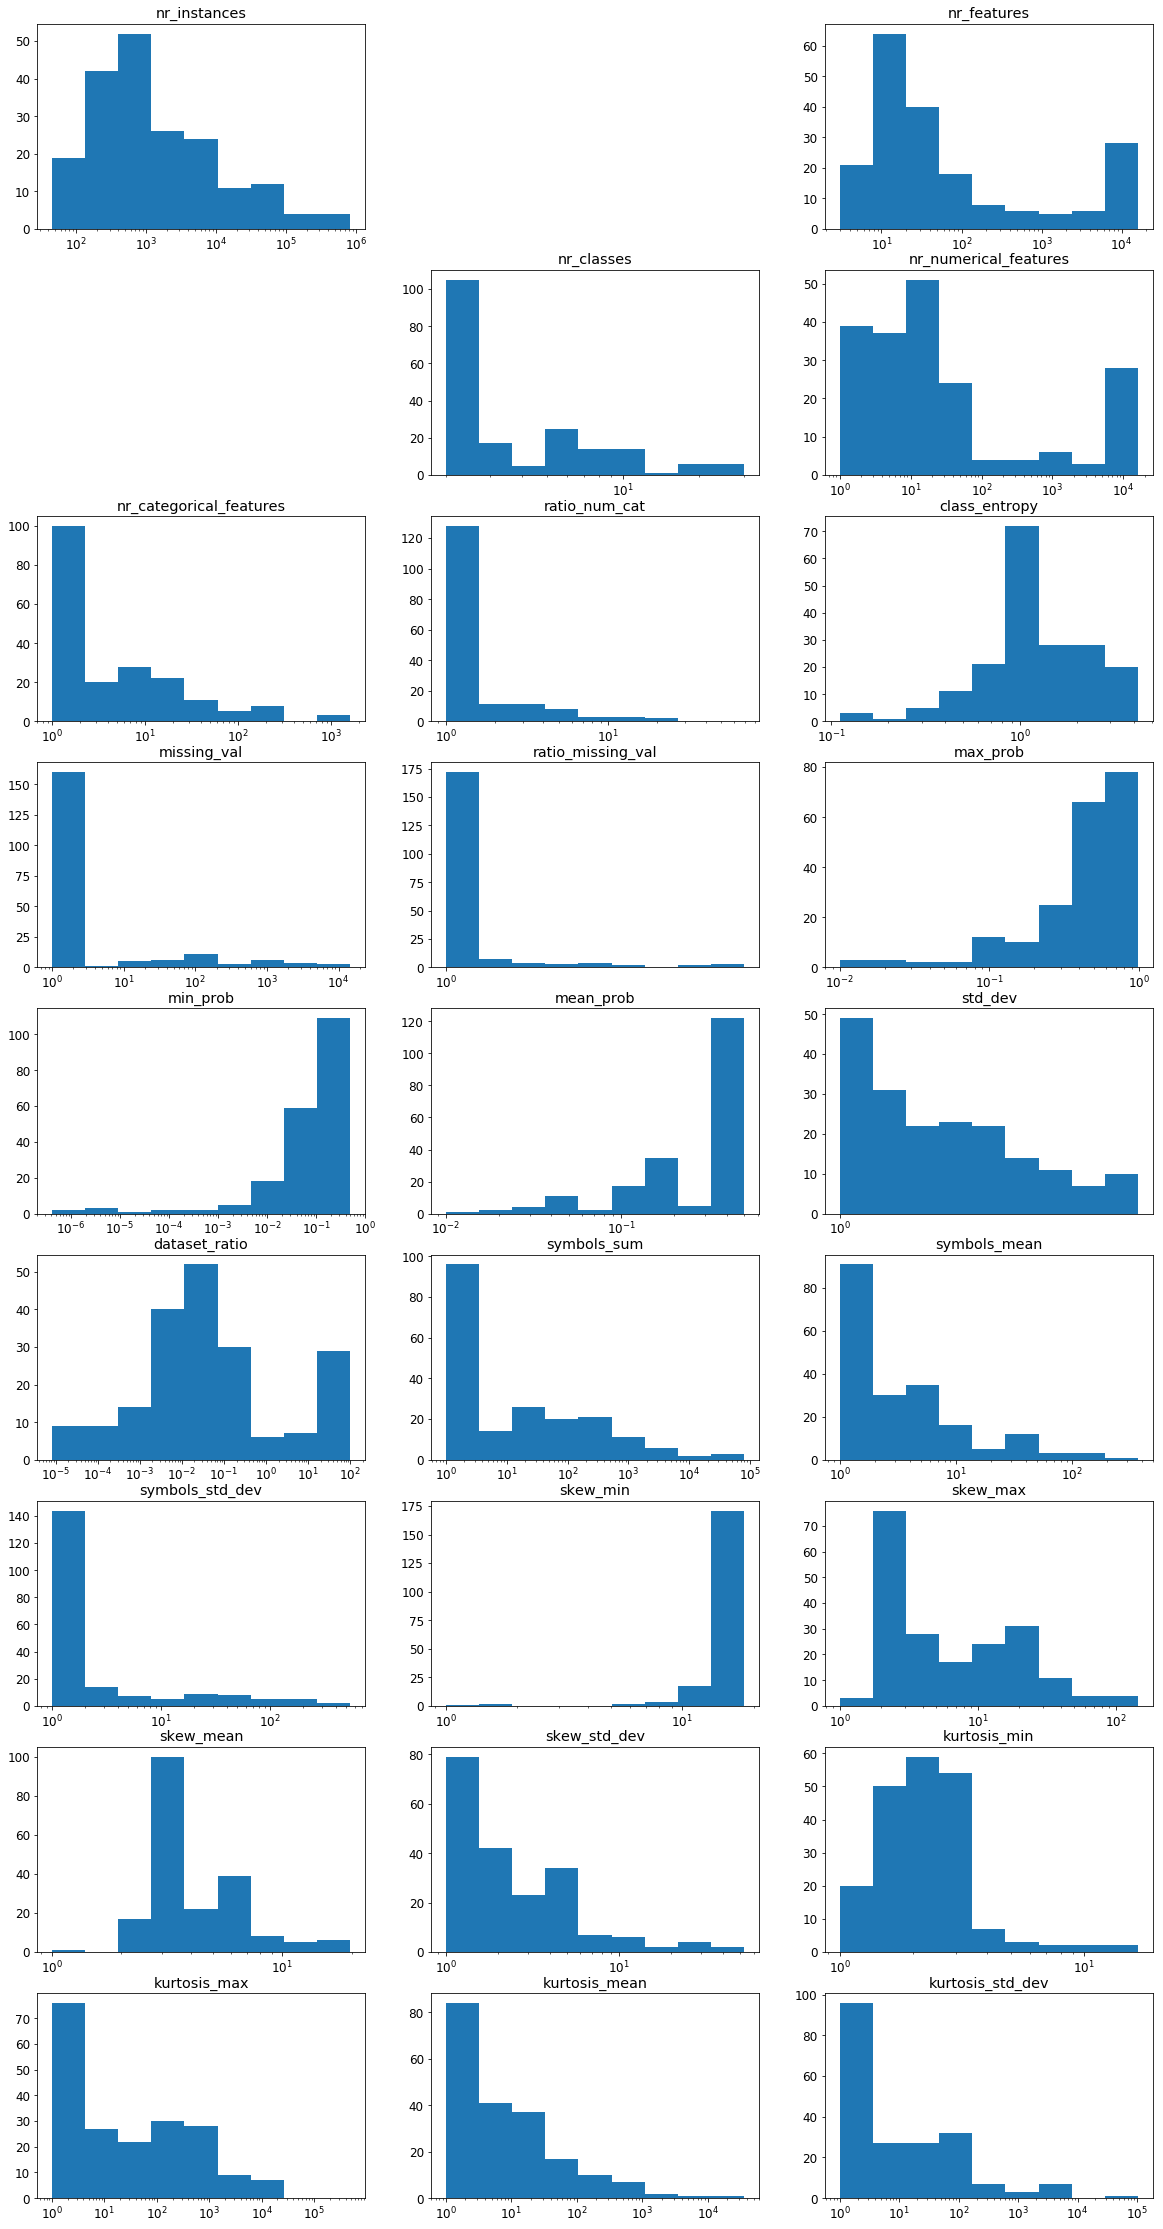

In [165]:
meta_data = copyMeta.copy()
def histogram(meta_data,meta_features_names):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams['figure.figsize'] = (20, 40)
    j=0
    print("Meta-Data Shape:", meta_data.shape)
    print("Length of Meta Features Names:", len(meta_features_names))
    for i in meta_data.T:
        text = meta_features_names[j]
        if j == 1 or j == 3:
            j += 1
            continue
            
        ax = plt.subplot(9,3,1+j)
        plt.xscale("log")

        plt.title('{}'.format(text))
        
        i = reject_outliers(i, 2)
        mini = min(i)
        maxi = max(i)    
        
        if mini <=  0:
            i -= (mini-1)
        
        #print('feature processing now: ', text, ' --- mini:', mini, ' --- maxi:', maxi, '===i===', j)
        plt.hist(i, bins = np.logspace(np.log10(min(i)), np.log10(max(i)), 10))

        j=j+1
    plt.savefig("All-Datasets.png")
    plt.show()
histogram(meta_data,meta_features_names)